In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from statsmodels.tsa.arima.model import ARIMA 
from scipy.stats import skew
from plotly.subplots import make_subplots
import pickle

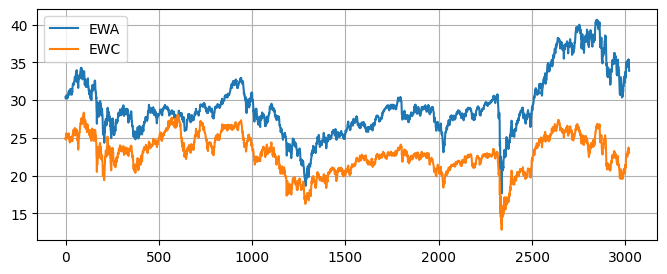

In [47]:
ewa = pd.read_csv("EWA.csv").iloc[:, 4].values.ravel()[:5000]
ewc = pd.read_csv("EWC.csv").iloc[:, 4].values.ravel()[:5000]
df = pd.DataFrame(data=dict(ewc=ewc, ewa=ewa))
plt.figure(figsize=(8, 3))
plt.grid()
plt.plot(df, zorder=2)
plt.legend(["EWA", "EWC"])
plt.show()

In [48]:
class KalmanTracking:
    def __init__(self, F, H, Q, R, z):
        self.F = F
        self.H = H
        self.Q = Q
        self.R = R
        self.z = z

        self.n = self.F.shape[0]
        self.h = self.z.shape[0]
        self.time_len = self.z.shape[1]

        self.estimation = np.zeros((self.n, self.time_len))
        self.kalman_gain = np.zeros((self.n, self.time_len))
        self.q_arr = np.zeros((self.h, self.time_len))
        self.spread = np.zeros((self.h, self.time_len))
        
    def update_H(self, i):
        return self.H[:, i].reshape(1, -1)

    def process_kalman(self):
        P_corrected = 1e-3 * np.eye(self.n)
        x_corrected = np.zeros((self.n, 1))
        for i in range(self.time_len):
            # prediction step
            x_predicted = self.F.dot(x_corrected)
            P_predicted = self.F.dot(P_corrected).dot(self.F.T) + self.Q

            # correction step
            H = self.update_H(i)
            y = self.z[:, i] - H.dot(x_predicted)
            S = H.dot(P_predicted).dot(H.T) + self.R
            K = P_predicted.dot(H.T).dot(np.linalg.inv(S))
            x_corrected = x_predicted + K.dot(y)
            P_corrected = (np.eye(self.n) - K.dot(H)).dot(P_predicted)

            self.estimation[:, i] = x_corrected.ravel()
            self.kalman_gain[:, i] = K.ravel()
            self.q_arr[0, i] = S.ravel()
            self.spread[0, i] = y.ravel()
            
    def get_estimation(self):
        return self.estimation

In [60]:
b1 = 1e-3 # >>>>>> ГИПЕРПАРАМЕТР <<<<<<
b2 = 1e-5 # >>>>>> ГИПЕРПАРАМЕТР <<<<<<
F, H, Q, R, z = np.eye(2), np.vstack([ewa.reshape(1, -1), np.ones_like(ewa.reshape(1, -1))]), np.array([[b1 / (1 - b1), 0], [0, b2 / (1 - b2)]]), 1e-1, df["ewc"].values.reshape(1, -1)
kf = KalmanTracking(F=F, H=H, Q=Q, R=R, z=z)
kf.process_kalman()
estimation = kf.get_estimation()
std = np.sqrt(kf.q_arr).ravel() # Стандартное отклонение
beta = estimation[0, :].ravel() # Коэффициент хэджирования
spread = kf.spread.ravel()[2:] # Спред

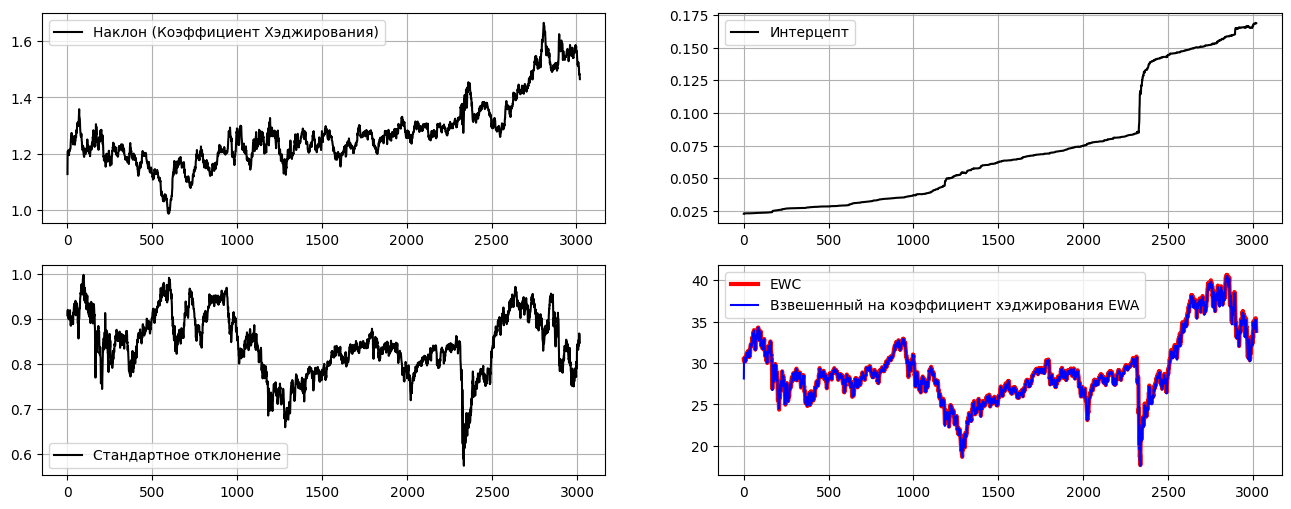

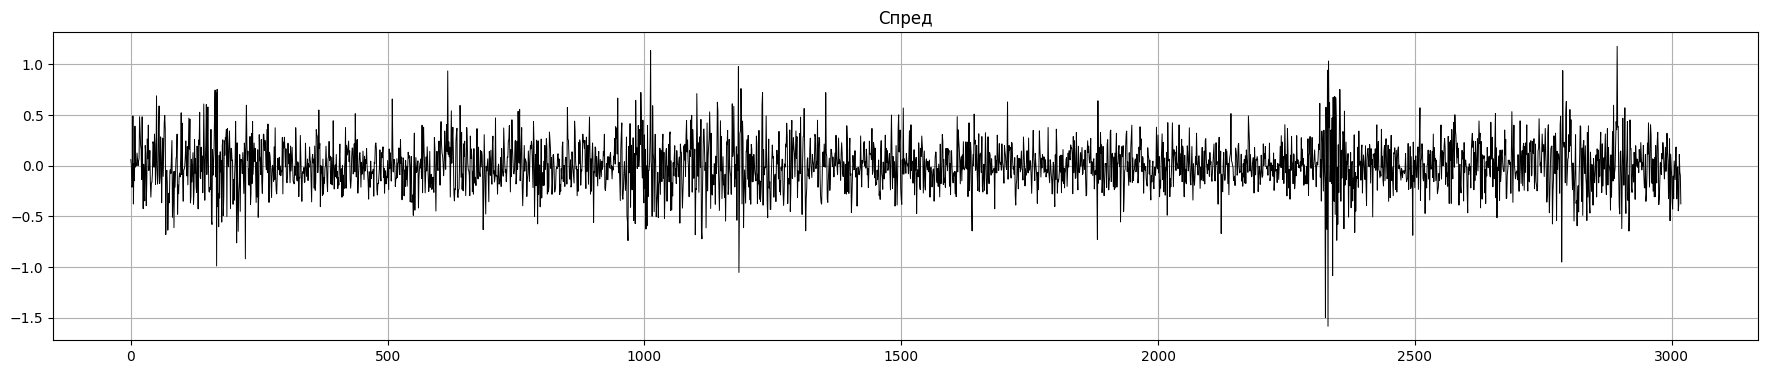

In [61]:
plt.figure(figsize=(16, 6))
plt.subplot(2, 2, 1)
plt.grid()
plt.plot(beta, zorder=2, color='k')
plt.legend(["Наклон (Коэффициент Хэджирования)"])
plt.subplot(2, 2, 2)
plt.grid()
plt.plot(estimation[1, :], zorder=2, color='k')
plt.legend(["Интерцепт"])
plt.subplot(2, 2, 3)
plt.grid()
plt.plot(np.sqrt(kf.q_arr.ravel())[3:], zorder=2, color='k')
plt.legend(["Стандартное отклонение"])
plt.subplot(2, 2, 4)
plt.grid()
plt.plot(ewc, color='red', zorder=2, linewidth=3)
plt.plot(beta * ewa.ravel(), color='blue', zorder=3)
plt.legend(["EWC", "Взвешенный на коэффициент хэджирования EWA"])
plt.show()

plt.figure(figsize=(22, 4))
plt.grid(True)
plt.plot(spread, linewidth=0.7, color='k', zorder=2)
plt.title("Спред")
plt.show()

# <center><h2> Стратегия с оптимальными трешхолдами</h2></center>

In [96]:
# трекинг теты и трекинг сигмы
b = 1e-3 # >>>>>> ГИПЕРПАРАМЕТР <<<<<<
F, H, Q, R, z = np.array([[1.]]).reshape(1, 1), spread[:-1].reshape(1, -1), np.array(b / (1 - b)).reshape(1, 1), np.array(1e-2).reshape(1, 1), np.array(spread[1:]).reshape(1, -1)
kf = KalmanTracking(F=F, H=H, Q=Q, R=R, z=z)
kf.process_kalman()
estimation_theta = kf.get_estimation().ravel()

def moving_std(spread):
    u = np.diff(spread)
    sigma = np.zeros_like(u)
    sigma[0] = np.square(u[0])
    alpha = 0.5 # >>>>>> ГИПЕРПАРАМЕТР <<<<<<
    for i in range(1, len(sigma)):
        sigma[i] = sigma[i - 1] * alpha + (1 - alpha) * u[i - 1] ** 2
    return np.sqrt(sigma)
moving_std = moving_std(spread)

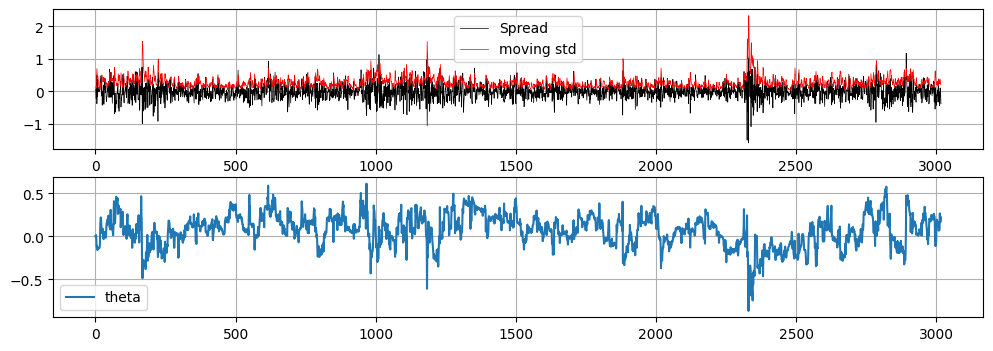

In [109]:
plt.figure(figsize=(12, 4))
plt.subplot(2, 1, 1)
plt.grid(True)
plt.plot(spread, zorder=2, color='k', linewidth=0.5)
plt.plot(moving_std, zorder=3, color='r', linewidth=0.5)
plt.legend(["Spread", "moving std"])
plt.subplot(2, 1, 2)
plt.grid(True)
plt.plot(estimation_theta)
plt.legend(["theta"])
plt.show()

In [101]:
path_to_pickle = "/workspace/GrishaR/spot/Fitting Ornstein Ulenbeck/optimal_parameters.pickle"
with open(path_to_pickle, "rb") as file:
    parameters = pickle.load(file)
sigma_dict = parameters["sigma"]
theta_dict = parameters["theta"]
thresholds = parameters["thresholds"]
opt_t = []
sigma = np.round(np.std(spread), 2)
for k in range(len(spread) - 1):
    theta = np.round(estimation_theta[k], 2)
    sigma = np.round(moving_std[k], 2)
    
    if sigma > 2.23:
        sigma = 2.23
    
    i, j = sigma_dict[sigma], theta_dict[theta]
    cur_thresh = thresholds[i, j]
    opt_t.append(cur_thresh)

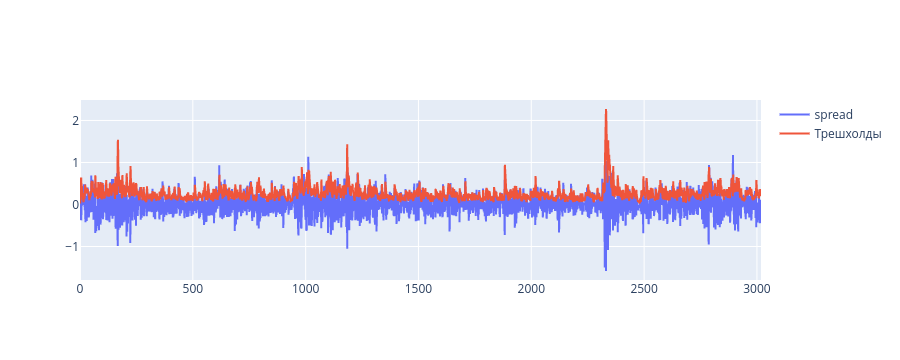

In [102]:
fig = go.Figure(data=[
    go.Scatter(y=spread, name="spread"),
    go.Scatter(y=opt_t, name="Трешхолды")
])
fig.show()

Цена спреда представляет собой процесс вида:
    $$spread(t) = s_{1}(t) - \beta(t)s_{2}(t)$$
    
где 

$s_{1}(t)$ Цена первого актива

$s_{2}(t)$ Цена второго актива

$spread(t)$ Цена спреда

Мы идем в шорт, когда цена спреда $spread(t)$ выше порога $thresh(t)$ и в этом случае

1) Продаем актив $s_{1}(t)$ (Берем в долг по высокой цене)
2) Покупаем актив $s_{2}(t)$ (Покупаем по более низкой цене)

Мы завершаем сделку когда спред возвращается к балансному положению и отдаем долг по более низкой цене $s_{2}(t)$

Мы идем в лонг когда цена спреда $spread(t)$ ниже порога $-thresh(t)$ и в этом случае

1) Покупаем актив $s_{1}(t)$ (По более низкой цене)
2) Продаем актив $s_{2}(t)$ (По более высокой цене)

Мы завершаем сделку когда спред возвращается к балансному положению и продаем актив $s_{1}(t)$

(Без учета долевой покупки)

В нашем случае спред имеет вид:
    $$spread(t) = EWC(t) - \beta(t)EWA(t)$$


In [103]:
pnl = np.diff(spread)
long_positions = np.zeros((len(spread) - 1, ))
short_positions = np.zeros((len(spread) - 1, ))
long_enabled = True
short_enabled = True
for i in range(1, len(spread) - 1):
    if long_enabled and spread[i] > opt_t[i]: # short only
        long_enabled = False
        long_positions[i] = -1
    if long_enabled == False and spread[i] < 0:
        long_enabled = True  
        
positions = long_positions.ravel() + short_positions.ravel()
print(positions.shape)
sample_returns = positions * pnl
equity_curve = np.cumsum(sample_returns)

(3018,)


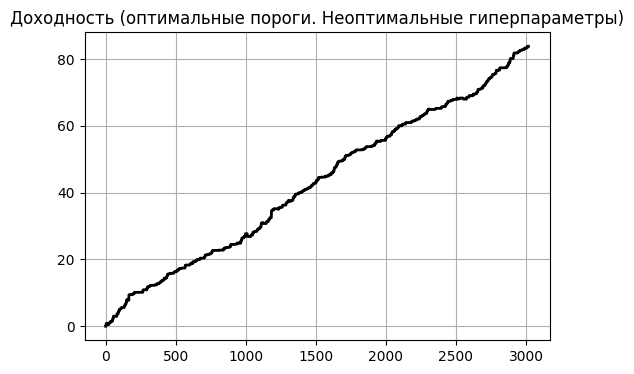

In [105]:
plt.figure(figsize=(6, 4))
plt.plot(equity_curve, color='k', linewidth=2, zorder=2)
plt.grid(True)
plt.title("Доходность (оптимальные пороги. Неоптимальные гиперпараметры)")
plt.show()

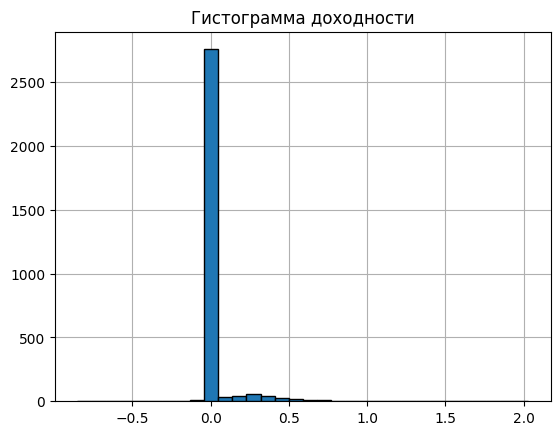

In [106]:
plt.figure()
plt.title("Гистограмма доходности")
plt.grid(True)
plt.hist(sample_returns, bins=32, zorder=3, edgecolor='k')
plt.show()

In [107]:
print(f"Средняя доходность: {np.mean(sample_returns)}")
print(f"Дисперсия: {np.square(np.std(sample_returns))}")
print(f"Коэффициент шарпа: {np.mean(sample_returns) / np.std(sample_returns)}")
print(f"Ассиметрия: {skew(sample_returns)} ")

Средняя доходность: 0.027777111110595294
Дисперсия: 0.014648669814395871
Коэффициент шарпа: 0.22950279609944746
Ассиметрия: 5.574804416330803 


In [284]:
num_units_short = [None] * len(spread)
num_units_long = [None] * len(spread)
num_units_short[0] = 0
num_units_long[0] = 0

for i in range(len(spread)):
    if spread[i] <= -std[i]:
        num_units_long[i] = 1
    if spread[i] >= 0:
        num_units_long[i] = 0
        
for i in range(len(spread)):
    if spread[i] >= std[i]:
        num_units_short[i] = -1
    if spread[i] <= 0:
        num_units_short[i] = 0
dataframe = pd.DataFrame()
dataframe["num_units_long"] = num_units_long
dataframe["num_units_short"] = num_units_short
dataframe.head()

,num_units_long,num_units_short
0,0.0,-1.0
1,0.0,NaN
2,NaN,0.0
3,NaN,0.0
4,0.0,NaN


In [141]:
dataframe.fillna(method="ffill", inplace=True)
dataframe["num_units"] = dataframe["num_units_long"].values + dataframe["num_units_short"].values
dataframe.head()

,num_units_long,num_units_short,num_units
0,0.0,-1.0,-1.0
1,0.0,-1.0,-1.0
2,1.0,0.0,1.0
3,1.0,0.0,1.0
4,1.0,0.0,1.0


In [144]:
positions = np.vstack([dataframe["num_units"].values, dataframe["num_units"].values]) \
            * np.vstack([-beta * ewa, ewc])
pnl = []
for i in range(len(positions)):
    profit1 = (positions[i, 0] - positions[i - 1, 0]) / positions[i - 1, 0]
    profit2 = (positions[i, 1] - positions[i - 1, 1] )/ positions[i - 1, 1]
    pnl.append(profit1 + profit2)